### Если не сраотал какой то импорт, надо поставить лабу типа того

In [20]:
#!pip install sklearn scipy torch torchmetrics

### Импорты

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'sans-serif'  # Здесь вы можете выбрать семейство шрифта, например 'serif', 'sans-serif', 'monospace'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']  # Здесь вы можете указать конкретные шрифты для выбранного семейства
plt.rcParams['font.size'] = 14  # Размер шрифта
plt.rcParams['axes.titlesize'] = 16  # Размер шрифта для заголовков осей
plt.rcParams['axes.labelsize'] = 14  # Размер шрифта для меток осей
plt.rcParams['xtick.labelsize'] = 12  # Размер шрифта для меток на оси X
plt.rcParams['ytick.labelsize'] = 12  # Размер шрифта для меток на оси Y
plt.rcParams['legend.fontsize'] = 12  # Размер шрифта для легенды

from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchmetrics import MeanAbsoluteError, R2Score, MeanSquaredError
import pickle  

def save_model(model, filename): #filename like 'model.pkl'
    with open(filename,'wb') as f:
        pickle.dump(model,f)

def load_model(filename):    
    with open(filename, 'rb') as f:
        model = pickle.load(f)
        return model
    
def smooth(df, sensor, out_sensor = None):
    out = sensor + '_Filtered' if out_sensor is None else out_sensor
    df[out] = df[sensor].ewm(alpha=0.1).mean()
    df[out] = df[out].ewm(alpha=0.01).mean()

### Загружаем только нужный кусок датасета

In [3]:
total =9199930
want = int(133/1425 * total)
skip = int(369/1425 * total)
header = ['year', 'month', 'day', 'hour', 'minute', 'second', 'AN311', 'AN422', 'AN423', 'TP1721', 'RH1722', 'BA1723', 'TP1711', 'RH1712', 'BA1713', 'MM252', 'MM261', 'MM262', 'MM263', 'MM264', 'MM256', 'MM211', 'CM861', 'CR863', 'P_864', 'TC862', 'WM868', 'AMP1_IR', 'AMP2_IR', 'DMP3_IR', 'DMP4_IR', 'AMP5_IR', 'F_SIDE', 'V']
df = pd.read_csv('methane_data.csv', nrows=want, skiprows=skip)
df.columns = header
df

,year,month,day,hour,minute,second,AN311,AN422,AN423,TP1721,...,P_864,TC862,WM868,AMP1_IR,AMP2_IR,DMP3_IR,DMP4_IR,AMP5_IR,F_SIDE,V
0,2014,3,29,13,44,57,3.6,1.6,1.4,24.5,...,93.9,32.9,3.38,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2014,3,29,13,44,58,3.6,1.6,1.4,24.5,...,93.9,32.9,3.38,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2014,3,29,13,44,59,3.8,1.6,1.4,24.5,...,93.9,32.9,3.33,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2014,3,29,13,45,0,3.8,1.6,1.4,24.5,...,93.9,32.9,3.33,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2014,3,29,13,45,1,3.9,1.6,1.5,24.5,...,93.9,32.9,3.35,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
858655,2014,4,8,13,15,52,3.3,1.5,1.2,24.8,...,94.3,33.2,2.51,0.0,0.0,0.0,0.0,0.0,0.0,0.0
858656,2014,4,8,13,15,53,3.3,1.5,1.2,24.8,...,94.3,33.2,2.51,0.0,0.0,0.0,0.0,0.0,0.0,0.0
858657,2014,4,8,13,15,54,3.3,1.5,1.2,24.8,...,94.4,33.2,2.55,0.0,0.0,0.0,0.0,0.0,0.0,0.0
858658,2014,4,8,13,15,55,3.3,1.5,1.2,24.8,...,94.4,33.2,2.55,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Удаляем бесполезные столбцы

In [4]:
sensors = df.drop(['year', 'month', 'day', 'hour', 'minute'], axis=1)

### Чистим от выбросов и фильтруем MM256

In [5]:
s2 = sensors.copy()
s2 = s2[(s2['CM861'] < 60) & (s2['CM861'] > 47) & (s2['AN423'] >= 1) & (s2['MM256'] <= 1.5) & (s2['MM256'] >= 0.2)] #избавляемся от выбросов
s2['second'] = range(len(s2))
s2 = s2[(s2['second'] < 320000) | (s2['second'] > 325000)]
s2['second'] = range(len(s2))
smooth(s2, 'MM256')
s2.set_index('second')

,AN311,AN422,AN423,TP1721,RH1722,BA1723,TP1711,RH1712,BA1713,MM252,...,TC862,WM868,AMP1_IR,AMP2_IR,DMP3_IR,DMP4_IR,AMP5_IR,F_SIDE,V,MM256_Filtered
second,,,,,,,,,,,,,,,,,,,,,
0,3.6,1.6,1.4,24.5,49,1115.6,28.7,65,1114.9,0.1,...,32.9,3.38,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.300000
1,3.6,1.6,1.4,24.5,49,1115.6,28.7,65,1114.9,0.1,...,32.9,3.38,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.300000
2,3.8,1.6,1.4,24.5,49,1115.6,28.7,65,1114.9,0.1,...,32.9,3.33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.300000
3,3.8,1.6,1.4,24.5,49,1115.6,28.7,65,1114.9,0.1,...,32.9,3.33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.300000
4,3.9,1.6,1.5,24.5,49,1115.6,28.7,65,1114.9,0.0,...,32.9,3.35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.300000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
782583,3.3,1.5,1.2,24.8,52,1101.5,29.1,69,1101.1,0.1,...,33.2,2.51,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.400141
782584,3.3,1.5,1.2,24.8,52,1101.5,29.1,69,1101.1,0.1,...,33.2,2.51,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.400139
782585,3.3,1.5,1.2,24.8,52,1101.5,29.1,69,1101.1,0.1,...,33.2,2.55,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.400138


### Функция показа и/или сохранения графика

In [6]:
def make_graph(sensor, saveOnly = False):
    total = len(s2['MM256'])
    start = total*0.3
    two_days = 60*60*24*1
    s3 = s2.loc[start:start+two_days,:].copy()
    s3[sensor + '_Filtered'] = s3[sensor].ewm(alpha=0.1).mean()
    s3[sensor + '_Filtered'] = s3[sensor + '_Filtered'].ewm(alpha=0.01).mean()
    s3.set_index('second')

    plt.subplot(1, 2, 1)
    plt.plot(s3['second'], s3[sensor], label=sensor + ' сырые данные', color='#cccccc')
    plt.plot(s3['second'], s3[sensor + '_Filtered'], label=sensor + ' отфильтрованные данные', color='#000000')
    plt.xlabel('Секунды')
    plt.ylabel('Значения')
    plt.legend()
    plt.rcParams["figure.figsize"] = (28,9)
    plt.title('Сигнал ' + sensor + ' сенсора')
    if saveOnly:
        plt.savefig(sensor + '.png')
        plt.show()
    else:
        plt.show()

### Сенсоры для которых выведем график

In [7]:
numenumeric = ['AN311', 'AN422', 'AN423', 'TP1721', 'RH1722', 'BA1723', 'TP1711',
       'RH1712', 'BA1713', 'MM252', 'MM256', 'MM261', 'MM262', 'MM263', 'MM264',
       'MM211', 'CM861', 'CR863', 'P_864', 'TC862', 'WM868', 'AMP1_IR',
       'AMP2_IR', 'DMP3_IR', 'DMP4_IR', 'AMP5_IR', 'F_SIDE', 'V']

### Сам вывод графиков

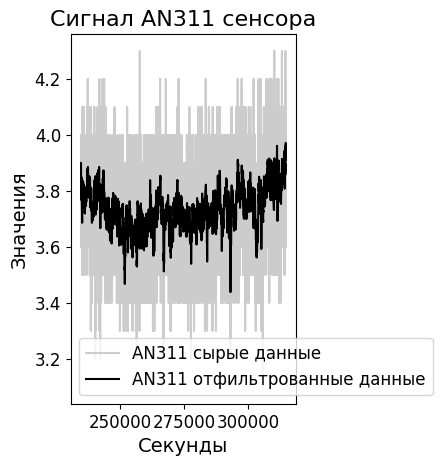

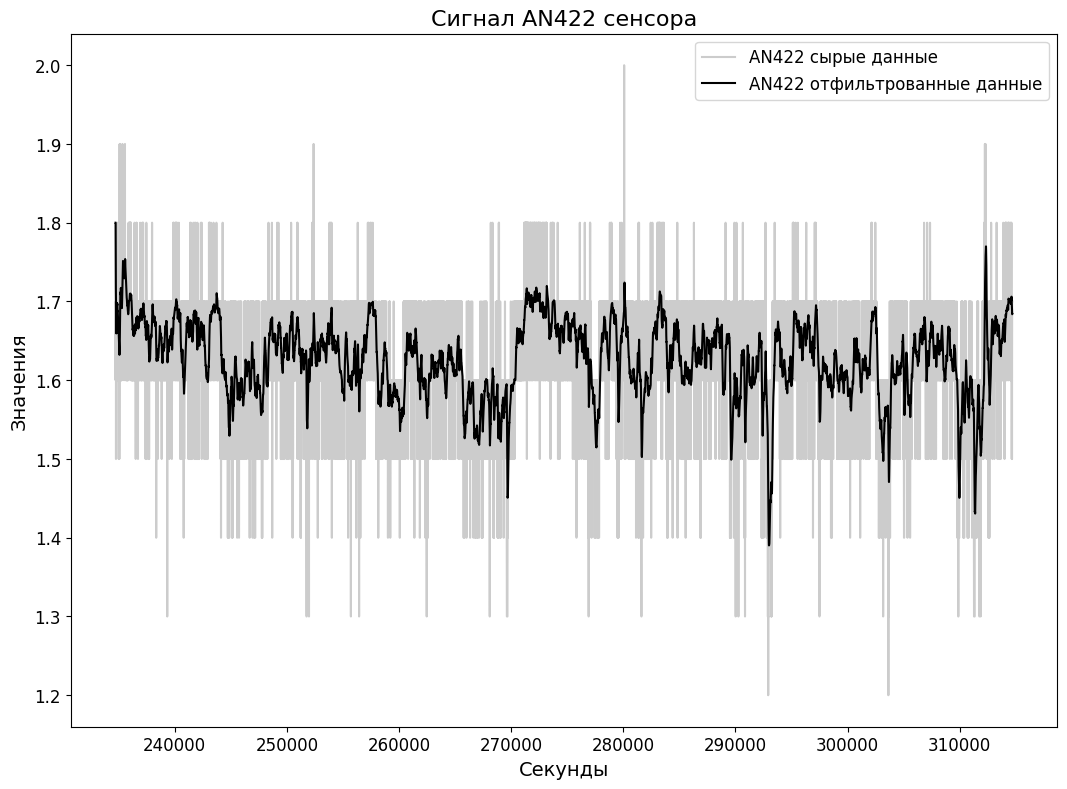

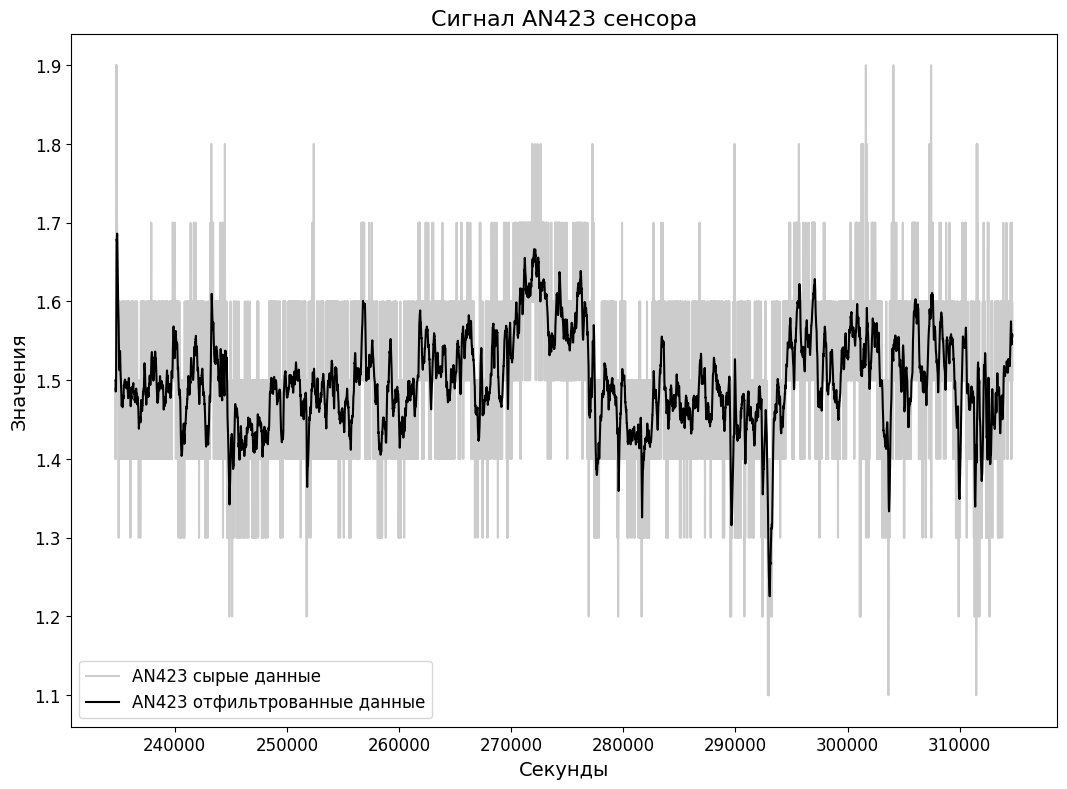

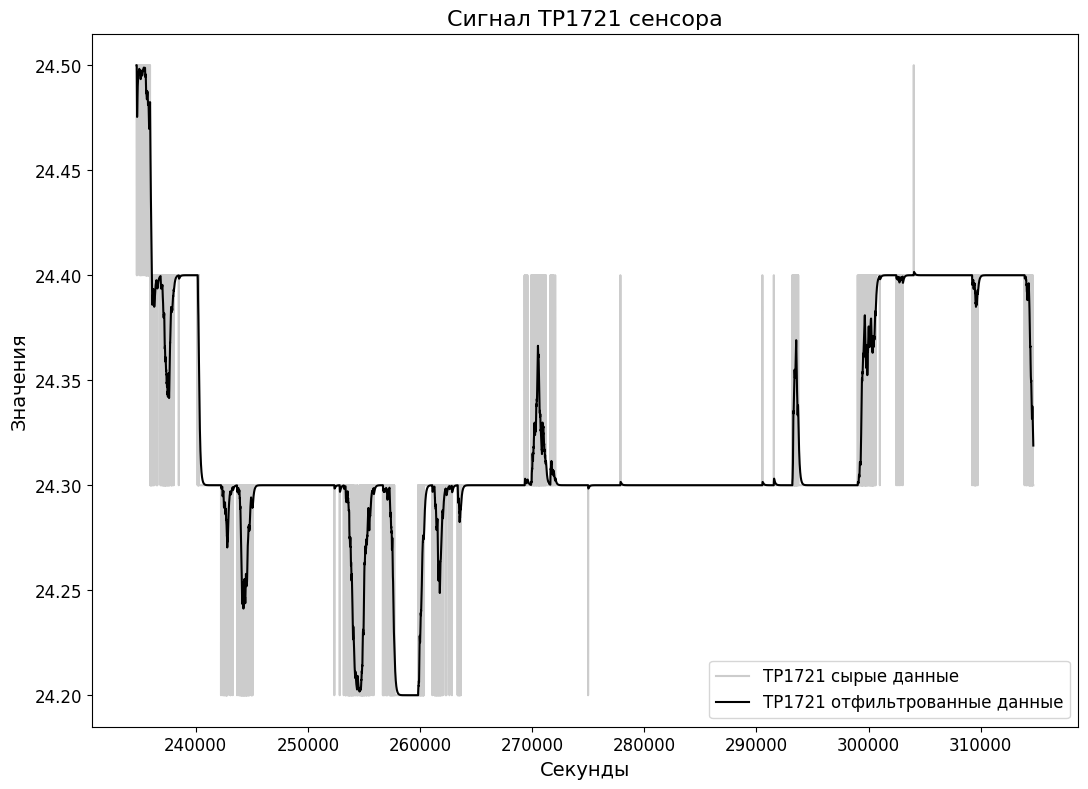

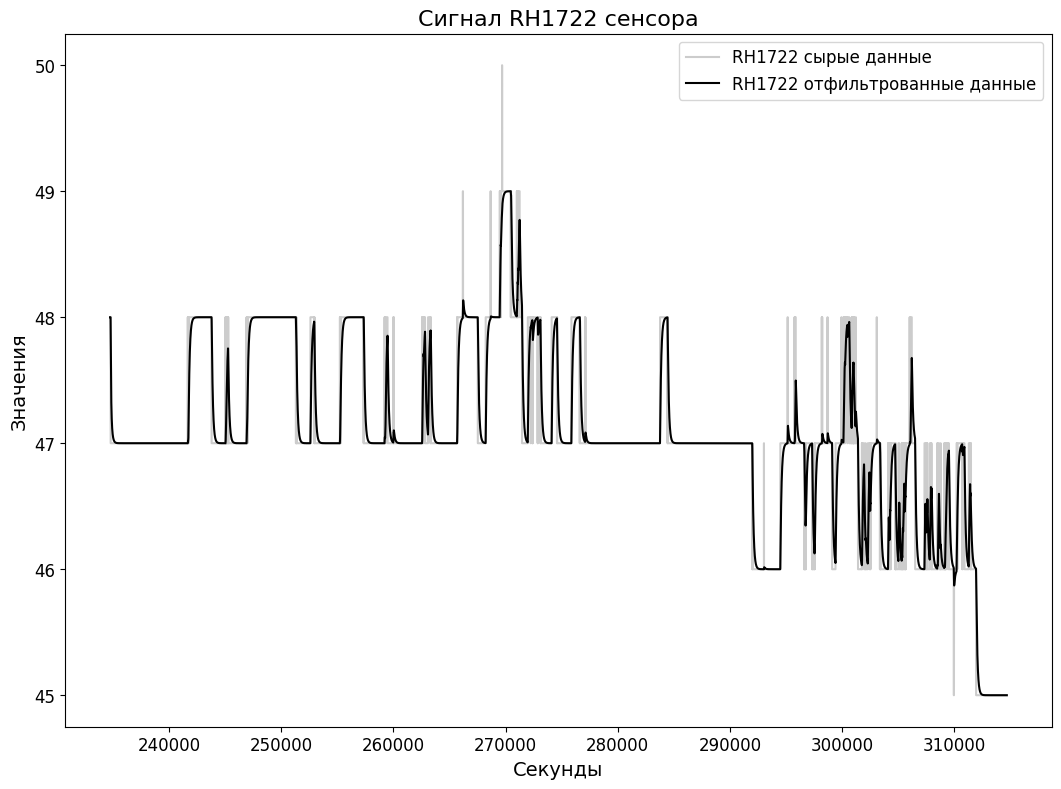

KeyboardInterrupt: 

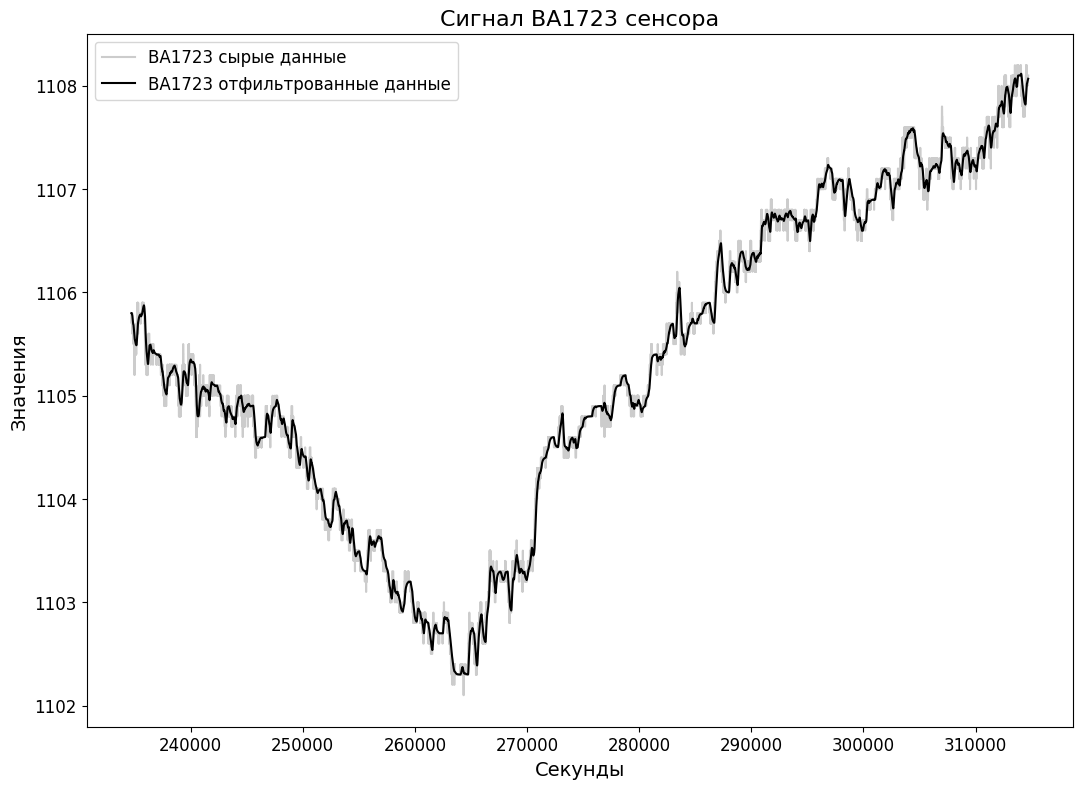

In [7]:
for sensor in numenumeric:
    make_graph(sensor, saveOnly=True)

### Для ML (random forest)

In [8]:
numeric = ['AN311', 'AN422', 'AN423', 'TP1721', 'RH1722', 'BA1723', 'TP1711',
       'RH1712', 'BA1713', 'MM252', 'MM256', 'MM261', 'MM262', 'MM263', 'MM264',
       'MM211', 'CM861', 'CR863', 'P_864', 'TC862', 'WM868']

column_trans = make_column_transformer(
    (MinMaxScaler(), numeric), # тут скейлер для численных признаков
    remainder='passthrough' # остальные пусть залетят так как есть
)

def useModel(model, X_train, X_test, y_train, y_test, current = []):
    pipe = make_pipeline(column_trans, model)
    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_test)
    score_train, score_test = pipe.score(X_train, y_train), pipe.score(X_test, y_test)
    mae = mean_absolute_error(y_test, pred)
    mse = mean_squared_error(y_test, pred)
    rmse = np.sqrt(mse)
    pred2 = pipe.predict(X_train)
    mae2 = mean_absolute_error(y_train, pred2)
    mse2 = mean_squared_error(y_train, pred2)
    rmse2 = np.sqrt(mse2)
    current.extend([score_test, score_train, mae, mse, rmse, mae2, mse2, rmse2])
    return pipe
        

In [9]:
def trrainModels(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)
    randforest = RandomForestRegressor(max_depth=100)
    metrics = []
    randforest = useModel(randforest, X_train, X_test, y_train, y_test, current=metrics)
    return randforest, metrics

#### Для тренировки леса: forest, metrics_forest = train_models_of_bias(seconds = SECONDS, df = DATAFRAME WITH MM256_Filtered COLUMN)
#### save_model(model, filename) - чтобы не потерять 5 часов своего времени
#### load_model(filename) - чтобы просто и быстро загрузить модель

In [10]:
def add_bias(n, tmp):
    y = tmp['MM256_Filtered'][n:]
    df = tmp.copy().iloc[:len(tmp) - n, :]
    df = df.drop(['second', 'MM256_Filtered'], axis=1)
    for sensor in numeric:
        smooth(df, sensor, sensor)
    df['y'] = list(y)
    return df

def df_to_forest_predict(df):
    df = df.drop(['second', 'MM256_Filtered'], axis=1)
    for sensor in numeric:
        smooth(df, sensor, sensor)
    return df

def train_models_of_bias(seconds, df):
    df_with_bias = add_bias(seconds, df)
    y = df_with_bias['y']
    X = df_with_bias.drop(['y'], axis=1)
    return trrainModels(X, y)

## На 1 секунду вперед

In [11]:
forest1, metrics_forest1 = train_models_of_bias(seconds = 1, df = s2)

In [12]:
save_model(metrics_forest1, 'mf1.pkl')

In [13]:
save_model(forest1, 'forest_1sec.pkl')

: 

## На 60 секунд вперед

In [ ]:
forest60, metrics_forest60 = train_models_of_bias(seconds = 60, df = s2)
save_model(forest60, 'forest_60sec.pkl')
save_model(metrics_forest60, 'mf60.pkl')

## На 900 секунд вперед

In [ ]:
forest900, metrics_forest900 = train_models_of_bias(seconds = 900, df = s2)
save_model(forest900, 'forest_900sec.pkl')
save_model(metrics_forest900, 'mf900.pkl')

## Тут deep learning

In [10]:
torch.manual_seed(7)

numeric = ['AN311', 'AN422', 'AN423', 'TP1721', 'RH1722', 'BA1723', 'TP1711',
       'RH1712', 'BA1713', 'MM252', 'MM256', 'MM261', 'MM262', 'MM263', 'MM264',
       'MM211', 'CM861', 'CR863', 'P_864', 'TC862', 'WM868']

class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

def preprocessor(X):
    return ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric),
            ('passthrough', 'passthrough', [col for col in X.columns if col not in numeric])
        ]
    )

class LotsOfHidden(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(LotsOfHidden, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        x = self.sigmoid(x)
        return x

def trrainDeep(X, y, seconds, epochs):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)

    pp = preprocessor(X)    
    X_train_processed = pp.fit_transform(X_train)
    X_test_processed = pp.transform(X_test)

    scaler = MinMaxScaler()

    y_train_preprocessed = scaler.fit_transform(y_train.values.reshape(-1, 1))
    y_test_preprocessed = scaler.transform(y_test.values.reshape(-1, 1))

    train_dataset = CustomDataset(X_train_processed, y_train_preprocessed)
    test_dataset = CustomDataset(X_test_processed, y_test_preprocessed)

    batch_size = 32
    shuffle = True

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    input_dim = X_train_processed.shape[1]

    hidden_dim = 57

    model_complex = LotsOfHidden(input_dim, hidden_dim)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model_complex.parameters(), lr=0.001) # тут скорость обученя (lr) 0.001

    num_epochs = epochs
    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        model_complex.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model_complex(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * X_batch.size(0)

        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        model_complex.eval()
        running_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                outputs = model_complex(X_batch)
                loss = criterion(outputs, y_batch)
                running_loss += loss.item() * X_batch.size(0)

        epoch_test_loss = running_loss / len(test_loader.dataset)
        test_losses.append(epoch_test_loss)

        if epoch % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}')

    plt.figure(figsize=(16, 9))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs+1), train_losses, label='Ошибка на обучающем наборе данных')
    plt.plot(range(1, num_epochs+1), test_losses, label='Ошибка на тестовом наборе данных')
    plt.xlabel('Эпоха')
    plt.ylabel('Ошибка')
    plt.legend()
    plt.title(f"Кривая обучения - ошибки, для {seconds} секунды/секунд")
    
    plt.savefig('loss_'+str(seconds)+'_seconds.png')
    plt.show()

    mae_metric = MeanAbsoluteError()
    mse_metric = MeanSquaredError()
    r2_metric = R2Score()

    model_complex.eval()
    train_mae, train_r2, train_mse = 0.0, 0.0, 0.0
    with torch.no_grad():
        for X_batch, y_batch in train_loader:
            outputs = model_complex(X_batch)
            train_mae += mae_metric(outputs, y_batch).item() * X_batch.size(0)
            train_mse += mse_metric(outputs, y_batch).item() * X_batch.size(0)
            train_r2 += r2_metric(outputs, y_batch).item() * X_batch.size(0)
    final_train_mae = train_mae / len(train_loader.dataset)
    final_train_mse = train_mse / len(train_loader.dataset)
    final_train_rmse = np.sqrt(final_train_mse)
    final_train_r2 = train_r2 / len(train_loader.dataset)

    test_mae, test_r2, test_mse = 0.0, 0.0, 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model_complex(X_batch)
            test_mae += mae_metric(outputs, y_batch).item() * X_batch.size(0)
            test_mse += mse_metric(outputs, y_batch).item() * X_batch.size(0)
            test_r2 += r2_metric(outputs, y_batch).item() * X_batch.size(0)
    final_test_mae = test_mae / len(test_loader.dataset)
    final_test_mse = test_mse / len(train_loader.dataset)
    final_test_rmse = np.sqrt(final_test_mse)
    final_test_r2 = test_r2 / len(test_loader.dataset)

    metrics = [
        final_test_r2, final_train_r2,
        final_test_mae, final_test_mse, final_test_rmse,
        final_train_mae, final_train_mse, final_train_rmse
    ]

    return model_complex, metrics

def train_deep_of_bias(seconds, df, epochs):
    df_with_bias = add_bias(seconds, df)
    y = df_with_bias['y']
    X = df_with_bias.drop(['y'], axis=1)
    return trrainDeep(X, y, seconds, epochs)

### На 1 секунду

Epoch [1/20], Train Loss: 0.0016, Test Loss: 0.0004
Epoch [11/20], Train Loss: 0.0001, Test Loss: 0.0001


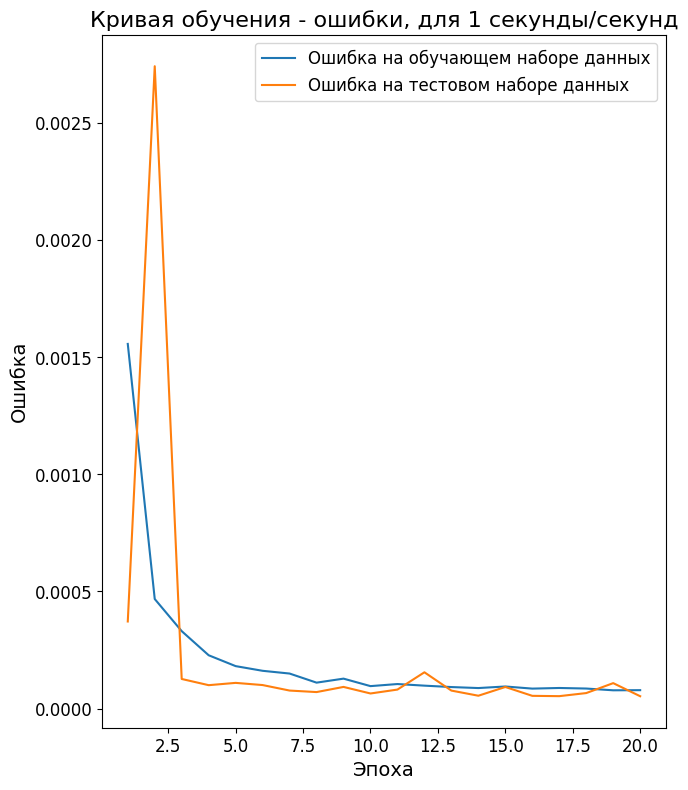

In [63]:
deep1, metrics_deep1 = train_deep_of_bias(seconds = 1, df = s2, epochs = 20)

In [64]:
save_model(metrics_deep1, 'md1.pkl')
torch.save(deep1, 'deep1.pkl')

### На 60 секунд

Epoch [1/47], Train Loss: 0.0016, Test Loss: 0.0014
Epoch [11/47], Train Loss: 0.0003, Test Loss: 0.0002
Epoch [21/47], Train Loss: 0.0002, Test Loss: 0.0003
Epoch [31/47], Train Loss: 0.0002, Test Loss: 0.0002
Epoch [41/47], Train Loss: 0.0002, Test Loss: 0.0003


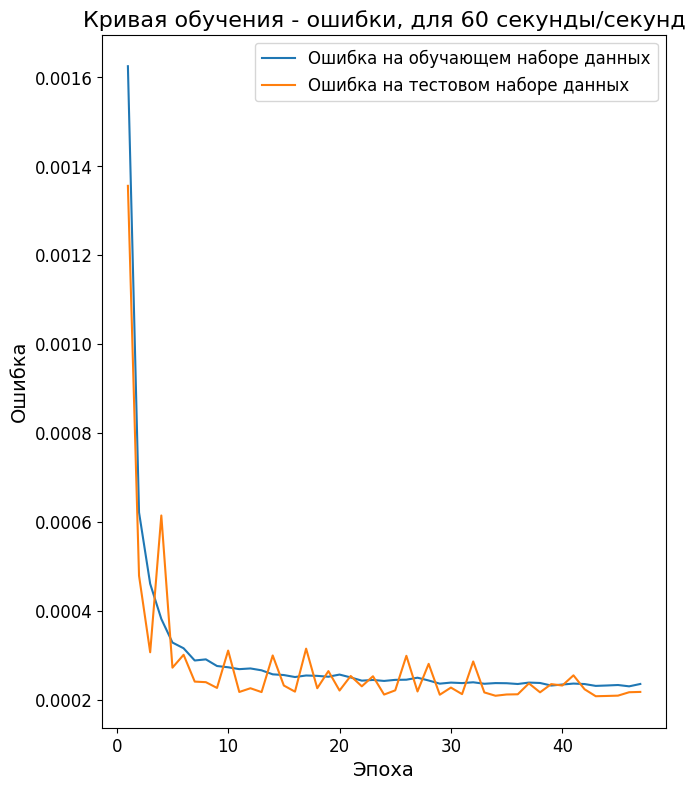

In [65]:
deep60, metrics_deep60 = train_deep_of_bias(seconds = 60, df = s2, epochs = 47)

In [66]:
torch.save(deep60, 'deep60.pkl')
save_model(metrics_deep60, 'md60.pkl')

### На 900 секунд

Epoch [1/40], Train Loss: 0.0039, Test Loss: 0.0026
Epoch [11/40], Train Loss: 0.0016, Test Loss: 0.0016
Epoch [21/40], Train Loss: 0.0015, Test Loss: 0.0015
Epoch [31/40], Train Loss: 0.0014, Test Loss: 0.0014


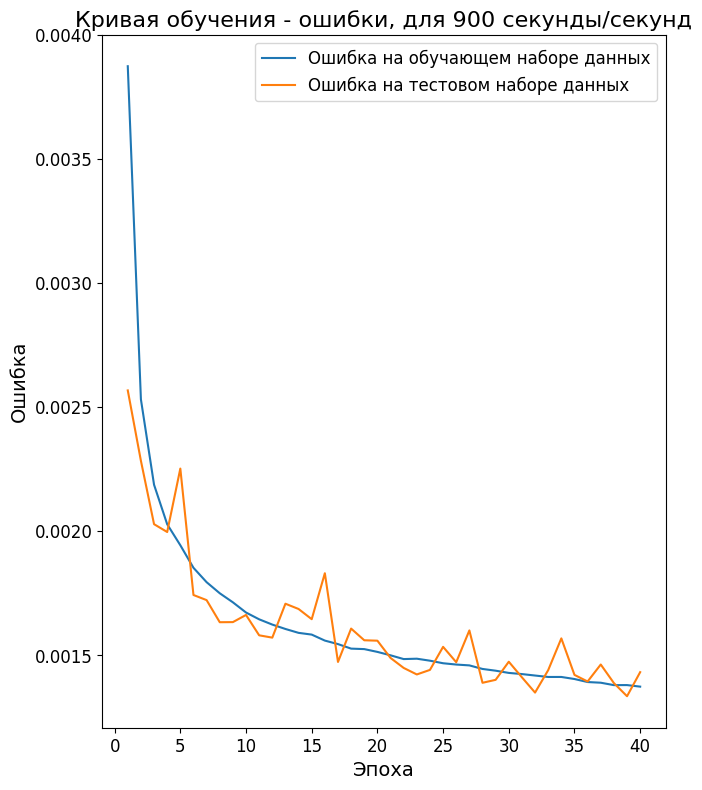

In [69]:
deep900, metrics_deep900 = train_deep_of_bias(seconds = 900, df = s2, epochs = 40)

In [70]:
torch.save(deep900, 'deep900.pkl')
save_model(metrics_deep900, 'md900.pkl')

## Графики для сравнения фильтрованного сигнала и предсказанного

для леса - make_final_graph_forest\
для нейронки - make_final_graph_deep

In [11]:
from matplotlib.pyplot import figure

def make_final_graph_deep(df, model, seconds, denormalize = True, real_test = False):
    sensor = 'MM256'
    X = df.drop(['second', 'MM256_Filtered'], axis=1)
    for s in numeric:
        smooth(X, s, s)
    pp = preprocessor(X)
    X = pp.fit_transform(X)    
    predicted = np.squeeze(model(torch.tensor(X, dtype=torch.float32)).detach().numpy())[seconds:]
    df = df.copy().iloc[seconds:,:]
    filtered = df[sensor + '_Filtered']
    raw = df[sensor]
    second = range(len(df))
    if denormalize:
        ymin, ymax = np.min(filtered), np.max(filtered)
        predicted = predicted * (ymax - ymin) + ymin
    draw(second, raw, filtered, predicted, sensor, seconds, 'deep', real_test)

def make_final_graph_forest(df, model, seconds, real_test = False):
    sensor = 'MM256'
    X = df.drop(['second', 'MM256_Filtered'], axis=1)
    for s in numeric:
        smooth(X, s, s)
    predicted = model.predict(X)[seconds:]
    df = df.copy().iloc[seconds:,:]
    filtered = df[sensor + '_Filtered']
    raw = df[sensor]
    second = range(len(df))
    draw(second, raw, filtered, predicted, sensor, seconds, 'forest', real_test)
   

def draw(second, raw, filtered, predicted, sensor, seconds, model, real_test):
    figure(figsize=(40, 16))
    plt.subplot(1, 2, 1)
    plt.plot(second, raw, label=sensor + ' сырые данные', color='#cccccc')
    plt.plot(second, filtered, label=sensor + ' отфильтрованные значения', color='#000000')
    plt.plot(second, predicted, label=sensor + ' спрогнозированные значения', color='#dd3355')
    plt.xlabel('Секунды')
    plt.ylabel('Значения')
    plt.legend()
    
    plt.title('Сигнал ' + sensor + ' сенсора')
    plt.savefig(sensor + '_real_test_' if real_test else '_' + model + '_for_' + str(seconds) + '_second.png')
    plt.show()

In [ ]:
forest1 = load_model('../forest_1sec.pkl')
make_final_graph_forest(s2, forest1, 1)

In [ ]:
forest60 = load_model('../forest_60sec.pkl')
make_final_graph_forest(s2, forest60, 60)

In [ ]:
forest900 = load_model('../forest_900sec.pkl')
make_final_graph_forest(s2, forest900, 900)

In [27]:
deep1 = load_model("../Pickles/deep1.pkl")
make_final_graph_deep(s2, deep1, 1)

UnpicklingError: A load persistent id instruction was encountered,
but no persistent_load function was specified.

In [16]:
deep60 = load_model("../Pickles/deep60.pkl")
make_final_graph_deep(s2, deep60, 60)

UnpicklingError: A load persistent id instruction was encountered,
but no persistent_load function was specified.

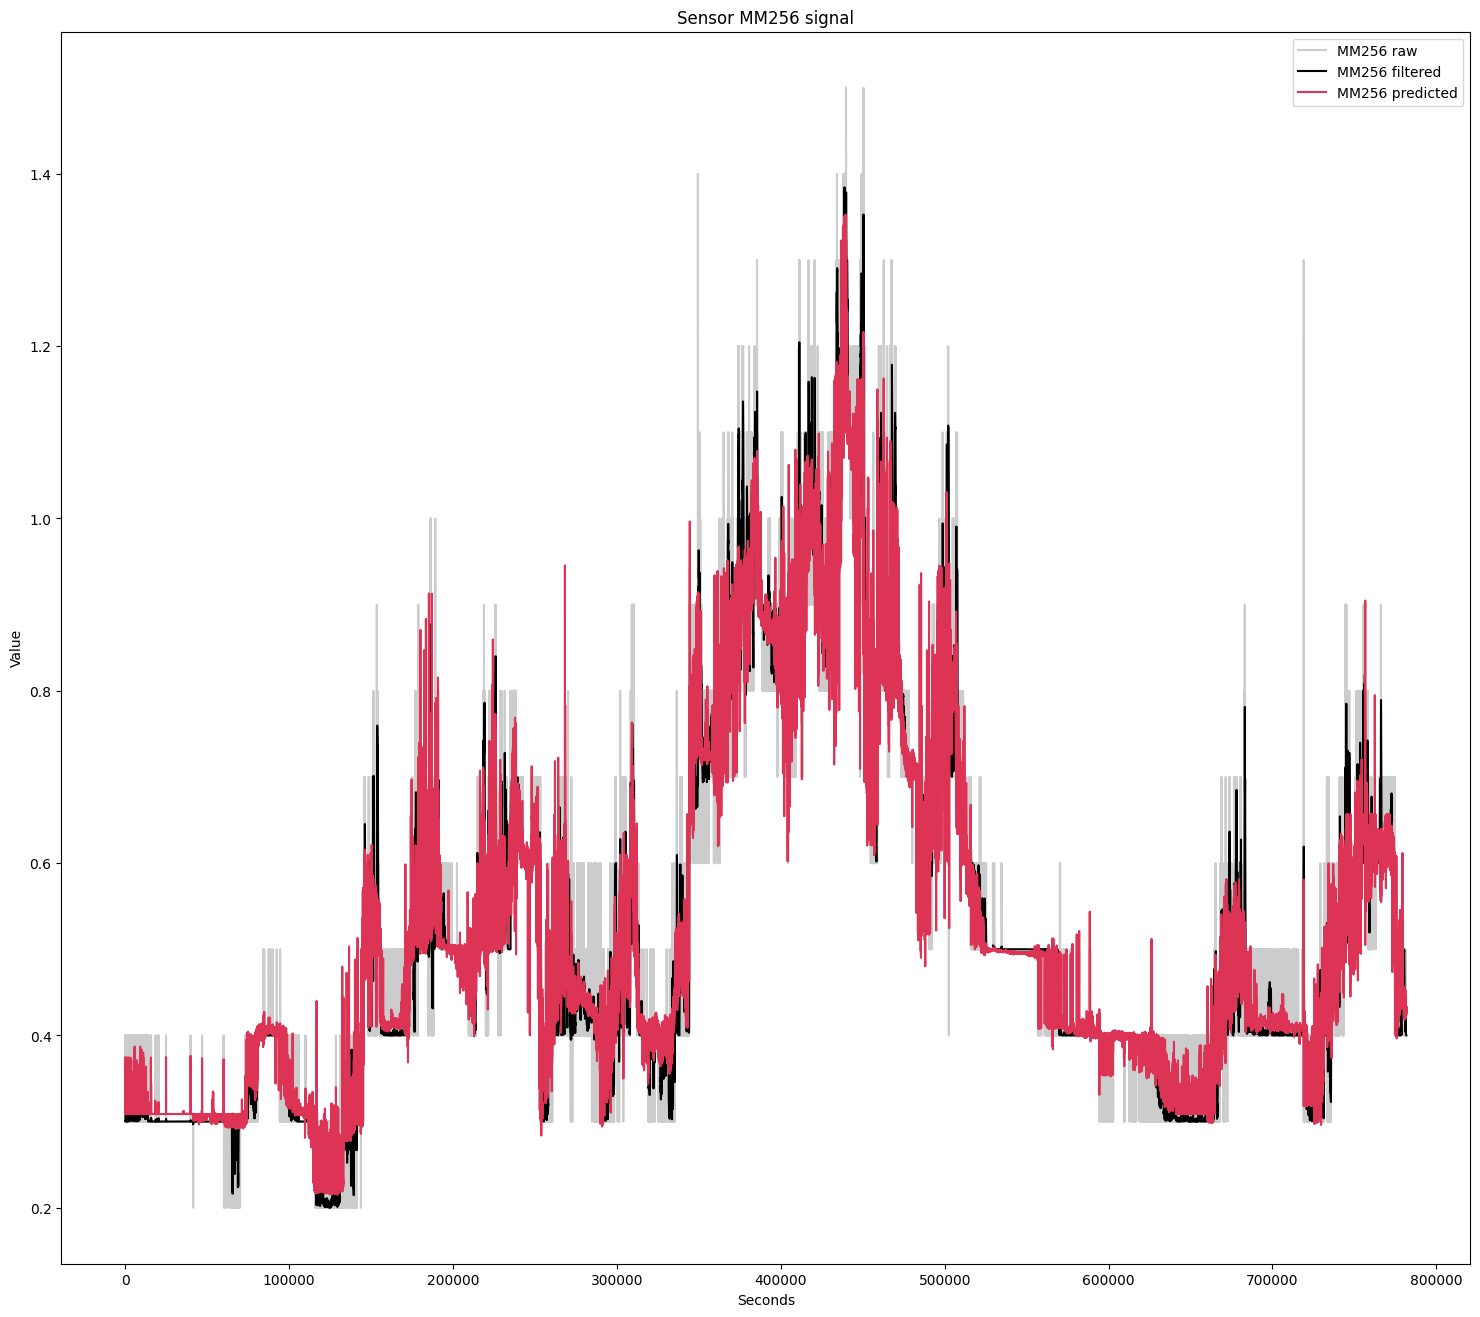

In [ ]:
deep900 = load_model("../Pickles/deep900.pkl")
make_final_graph_deep(s2, deep900, 900)

### Вывод метрик моделей

In [23]:
metrics_forest1 = load_model('../Pickles/mf1.pkl')
metrics_forest60 = load_model('../Pickles/mf60.pkl')
metrics_forest900 = load_model('../Pickles/mf900.pkl')
metrics_deep1 = load_model('../Pickles/md1.pkl')
metrics_deep60 = load_model('../Pickles/md60.pkl')
metrics_deep900 = load_model('../Pickles/md900.pkl')

In [24]:
models_rate = pd.DataFrame(columns=[
    'seconds',
    'f_r2_test', 'f_r2_train', 'f_mae_test', 'f_mse_test', 'f_rmse_test', 'f_mae_train', 'f_mse_train', 'f_rmse_train',
    'd_r2_test', 'd_r2_train', 'd_mae_test', 'd_mse_test', 'd_rmse_test', 'd_mae_train', 'd_mse_train', 'd_rmse_train',
])

models_rate.loc[len(models_rate)] = [1, *metrics_forest1, *metrics_deep1]
models_rate.loc[len(models_rate)] = [60, *metrics_forest60, *metrics_deep60]
models_rate.loc[len(models_rate)] = [900, *metrics_forest900, *metrics_deep900]

r2_rate = models_rate[['seconds', 'f_r2_test', 'd_r2_test', 'f_r2_train', 'd_r2_train']]
mae_rate = models_rate[['seconds', 'f_mae_test', 'd_mae_test', 'f_mae_train', 'd_mae_train']]
mse_rate = models_rate[['seconds', 'f_mse_test', 'd_mse_test', 'f_mse_train', 'd_mse_train']]
rmse_rate = models_rate[['seconds', 'f_rmse_test', 'd_rmse_test', 'f_rmse_train', 'd_rmse_train']]

In [26]:
r2_rate.set_index('seconds')

,f_r2_test,d_r2_test,f_r2_train,d_r2_train
seconds,,,,
1.0,0.999998,0.998281,1.000000,0.998092
60.0,0.999928,0.992946,0.999988,0.992763
900.0,0.999985,0.953791,0.999997,0.954698


In [14]:
mae_rate.set_index('seconds')

,f_mae_test,d_mae_test,f_mae_train,d_mae_train
seconds,,,,
1.0,0.000163,0.001406,0.00006,0.001412
60.0,0.000327,0.007134,0.00013,0.007171
900.0,0.000174,0.022547,0.00007,0.022485


In [15]:
mse_rate.set_index('seconds')

,f_mse_test,d_mse_test,f_mse_train,d_mse_train
seconds,,,,
1.0,1.061081e-07,0.000023,1.478440e-08,0.000059
60.0,3.434814e-06,0.000093,5.692642e-07,0.000223
900.0,7.364348e-07,0.000613,1.616935e-07,0.001413


In [16]:
rmse_rate.set_index('seconds')

,f_rmse_test,d_rmse_test,f_rmse_train,d_rmse_train
seconds,,,,
1.0,0.000326,0.004772,0.000122,0.007657
60.0,0.001853,0.009652,0.000754,0.014933
900.0,0.000858,0.024765,0.000402,0.037595


In [ ]:
total =9199930
want = int(180/1425 * total)
skip = int(450/1425 * total)
header = ['year', 'month', 'day', 'hour', 'minute', 'second', 'AN311', 'AN422', 'AN423', 'TP1721', 'RH1722', 'BA1723', 'TP1711', 'RH1712', 'BA1713', 'MM252', 'MM261', 'MM262', 'MM263', 'MM264', 'MM256', 'MM211', 'CM861', 'CR863', 'P_864', 'TC862', 'WM868', 'AMP1_IR', 'AMP2_IR', 'DMP3_IR', 'DMP4_IR', 'AMP5_IR', 'F_SIDE', 'V']
real_test = pd.read_csv('methane_data.csv', nrows=want, skiprows=skip)
real_test.columns = header
real_test = real_test.drop(['year', 'month', 'day', 'hour', 'minute'], axis=1)
real_test = real_test[(real_test['CM861'] < 60) & (real_test['CM861'] > 47) & (real_test['AN423'] >= 1) & (real_test['MM256'] <= 1.5) & (real_test['MM256'] >= 0.2)] #избавляемся от выбросов
real_test['second'] = range(len(real_test))
real_test['MM256_Filtered'] = real_test['MM256'].ewm(alpha=0.1).mean()
real_test['MM256_Filtered'] = real_test['MM256_Filtered'].ewm(alpha=0.01).mean()
real_test

,second,AN311,AN422,AN423,TP1721,RH1722,BA1723,TP1711,RH1712,BA1713,...,TC862,WM868,AMP1_IR,AMP2_IR,DMP3_IR,DMP4_IR,AMP5_IR,F_SIDE,V,MM256_Filtered
0,0,3.6,1.5,1.3,24.8,52,1098.3,29.5,76,1097.8,...,33.5,3.96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.800000
1,1,3.6,1.5,1.3,24.8,52,1098.3,29.5,76,1097.8,...,33.5,3.96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.800000
2,2,3.5,1.5,1.3,24.7,52,1098.3,29.5,76,1097.8,...,33.5,4.07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.800000
3,3,3.5,1.5,1.3,24.7,52,1098.3,29.5,76,1097.8,...,33.5,4.07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.800000
4,4,3.4,1.5,1.3,24.7,52,1098.3,29.5,76,1097.8,...,33.5,3.99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.800000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1162091,467352,3.9,1.6,1.6,24.8,44,1105.9,28.8,74,1105.2,...,32.9,2.53,5.0,4.0,5.0,4.0,0.0,0.0,0.0,0.978925
1162092,467353,3.8,1.6,1.6,24.8,44,1105.9,28.8,74,1105.2,...,32.9,2.53,5.0,5.0,5.0,4.0,0.0,0.0,0.0,0.978636
1162093,467354,3.8,1.6,1.6,24.8,44,1105.9,28.8,73,1105.2,...,32.9,2.53,5.0,5.0,5.0,4.0,0.0,0.0,0.0,0.978400
1162094,467355,3.7,1.6,1.5,24.8,44,1105.9,28.8,73,1105.2,...,32.9,2.53,5.0,5.0,6.0,4.0,0.0,0.0,0.0,0.978211


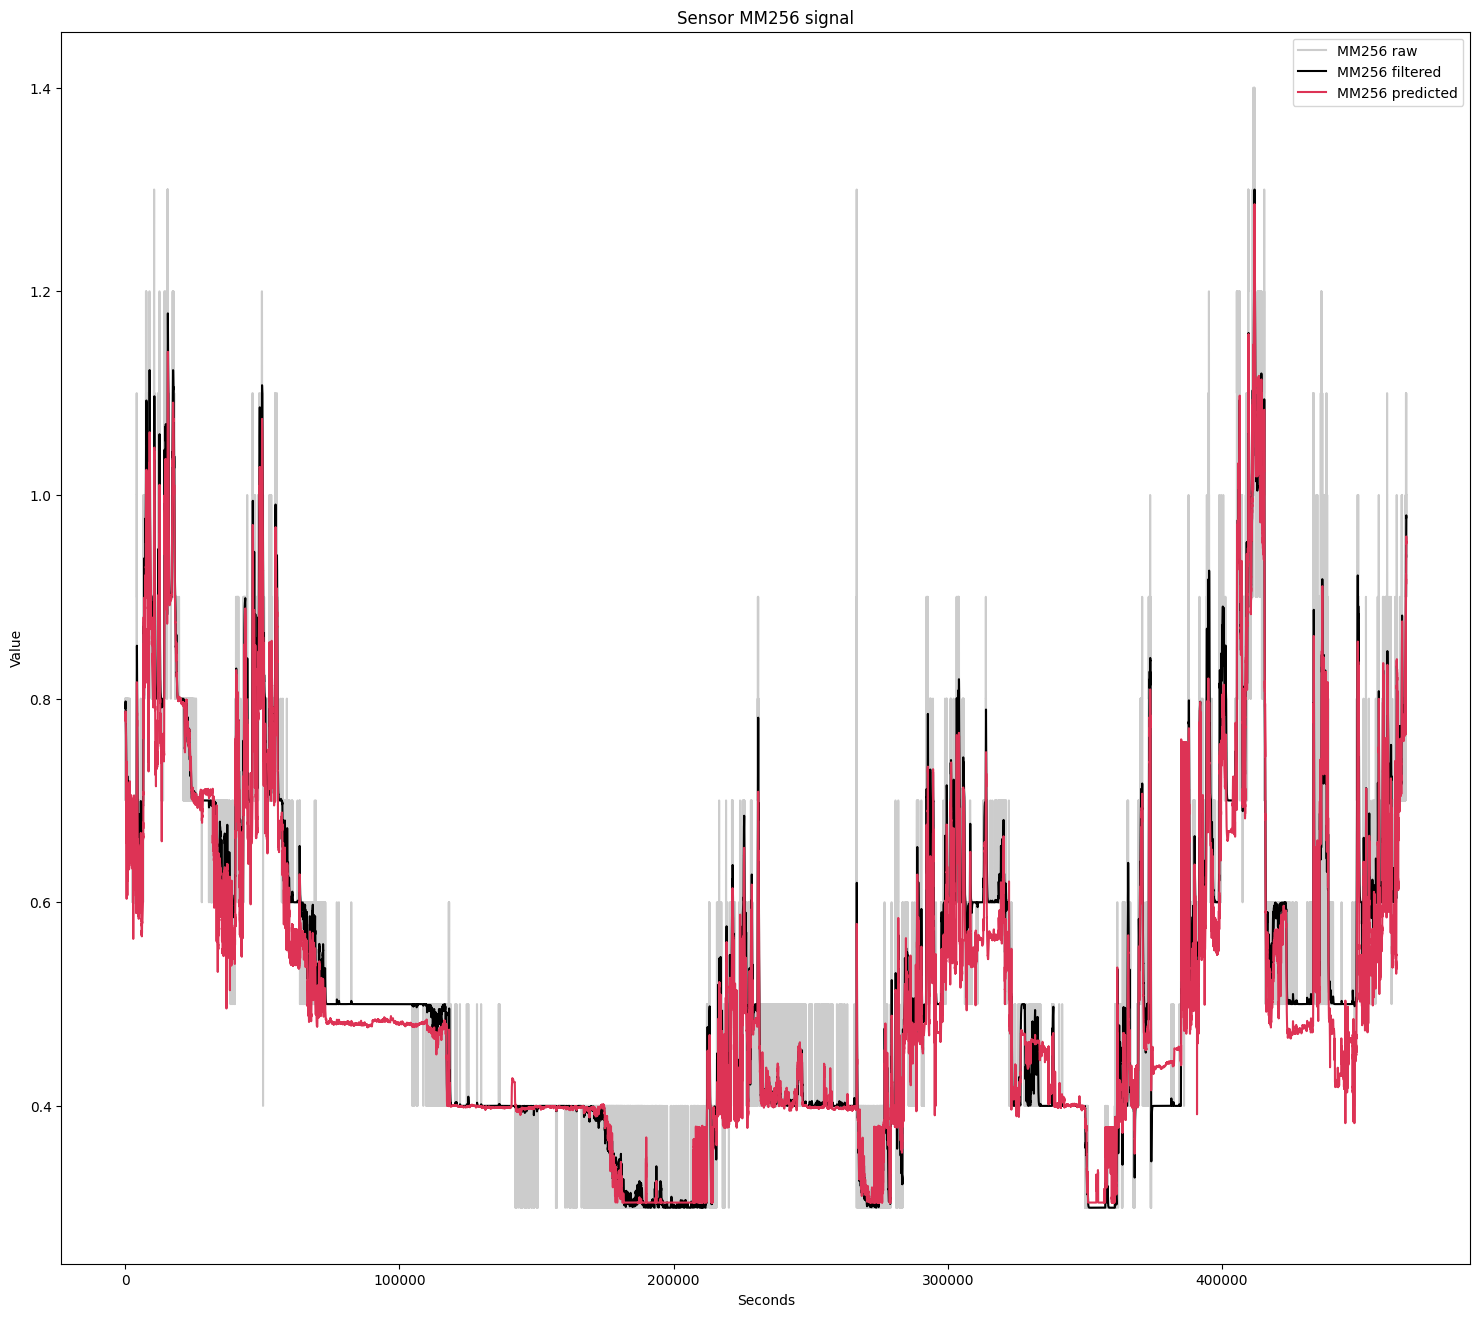

In [ ]:
deep = torch.load('deep60.pkl')
make_final_graph_deep(real_test, deep, 60)

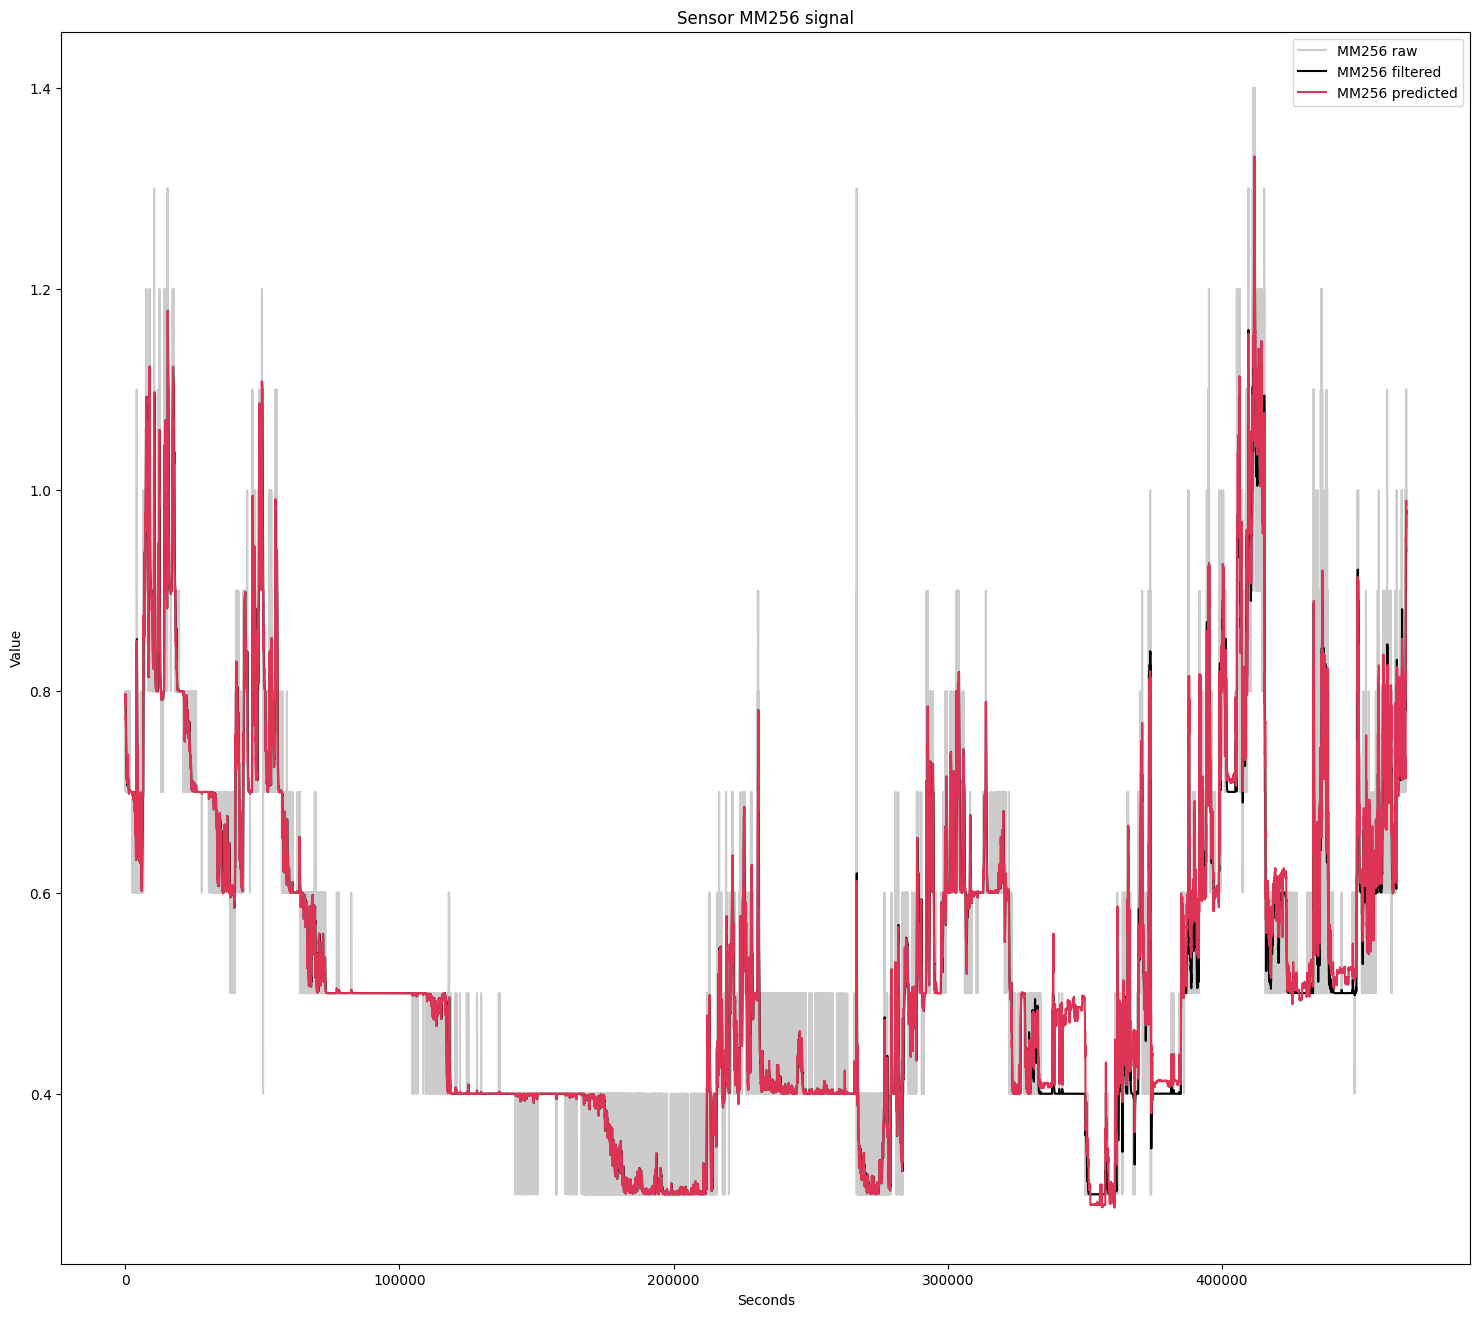

In [ ]:
forest = load_model('forest_60sec.pkl')
make_final_graph_forest(real_test, forest, 60)